# Example 12: Sequence-to-Scalar Prediction

Not all system identification tasks predict a full output sequence. Sometimes
the target is a single scalar -- a physical parameter, a classification label,
or a summary statistic. This example builds a custom data pipeline with
`ScalarBlock` and uses `SeqAggregation` to reduce RNN output to a scalar
prediction.

## Prerequisites

This example builds on [Example 00](00_your_first_model.py) and
[Example 01](01_data_pipeline.py). Make sure the library is installed:

```bash
uv sync --extra dev
```

## Setup

In [1]:
from pathlib import Path

import torch.nn as nn
from fastai.data.block import DataBlock
from tsfast.data.split import ParentSplitter
from fastai.learner import Learner
from fastai.optimizer import Adam

from tsfast.data.block import SequenceBlock, ScalarBlock
from tsfast.data.core import (
    get_hdf_files,
    CreateDict,
    DfHDFCreateWindows,
    TensorScalarsOutput,
)
from tsfast.models.rnn import SimpleRNN
from tsfast.models.layers import SeqAggregation
from tsfast.learner.losses import fun_rmse

## The Task: Estimating Initial Conditions

We have spring-damper trajectories with different initial positions (`x0`) and
velocities (`v0`). Given the full time series `[u, x, v]` -- force input,
position, and velocity -- can a neural network estimate what the initial
conditions were?

This is a **sequence-to-scalar regression** problem: the input is a multi-
channel time series and the output is a fixed-size vector `[x0, v0]`.

## Load the Dataset

The `pinn_var_ic` test data contains HDF5 files organized into `train/`,
`valid/`, and `test/` directories. Each file stores a 500-step spring-damper
trajectory with the force input `u`, position `x`, and velocity `v` as
datasets, plus scalar attributes like `x0` (initial position) and `v0`
(initial velocity).

In [2]:
def _find_project_root(marker: str = "test_data") -> Path:
    """Walk up from script/notebook location to find the project root."""
    try:
        start = Path(__file__).resolve().parent
    except NameError:
        start = Path(".").resolve()
    p = start
    while p != p.parent:
        if (p / marker).is_dir():
            return p
        p = p.parent
    raise FileNotFoundError(f"Could not find '{marker}' directory above {start}")


_root = _find_project_root()
data_path = _root / "test_data" / "pinn_var_ic"

files = get_hdf_files(data_path)
print(f"Found {len(files)} HDF5 files")
for f in files[:5]:
    print(f"  {f.parent.name}/{f.name}")

Found 34 HDF5 files
  train/x0_v0_step.h5
  train/x0p5_vn1p5_step.h5
  train/x0p5_vn1p5_sine_05hz.h5
  train/xn1_v0_sine_1hz.h5
  train/xn1_v0_multisine.h5


## Building a Custom DataBlock

Unlike `create_dls` which creates sequence-to-sequence pipelines, here we need
a custom `DataBlock` with:

- **Input:** `SequenceBlock` reading `[u, x, v]` columns as a multi-channel
  time series
- **Target:** `ScalarBlock` reading `[x0, v0]` from HDF5 file attributes

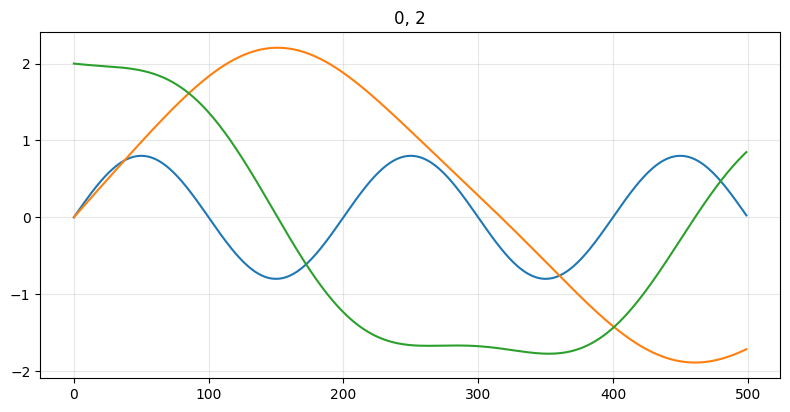

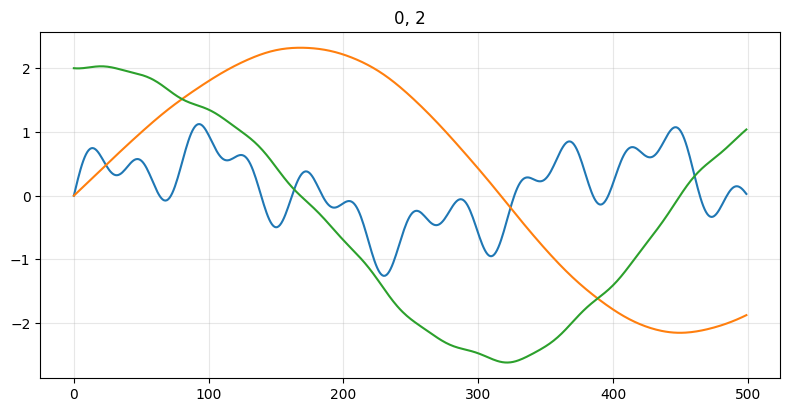

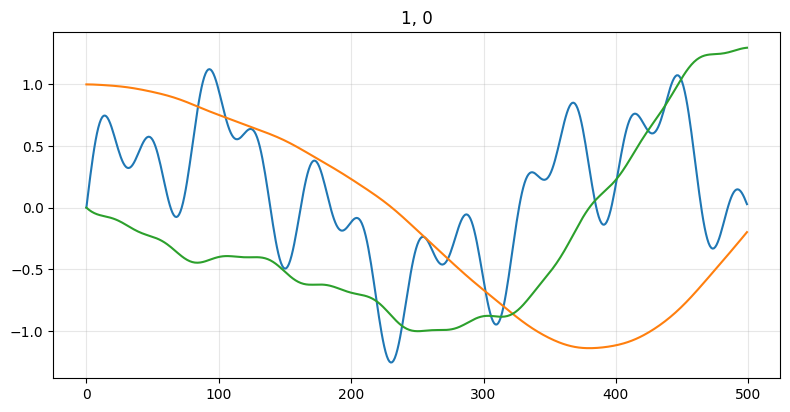

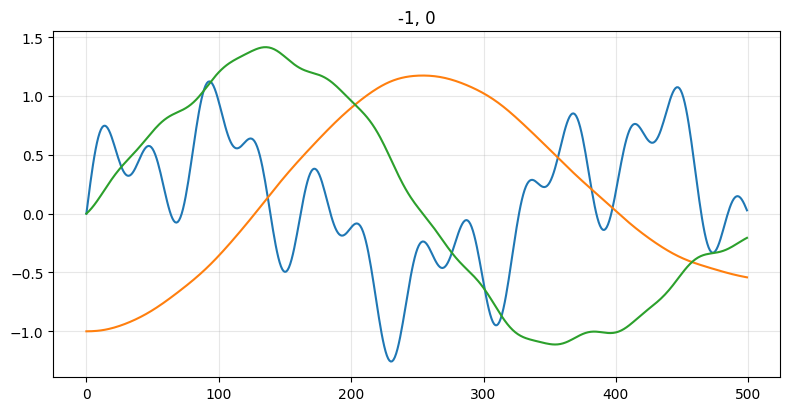

In [3]:
dblock = DataBlock(
    blocks=(
        SequenceBlock.from_hdf(['u', 'x', 'v']),
        ScalarBlock.from_hdf_attrs(['x0', 'v0'], scl_cls=TensorScalarsOutput),
    ),
    get_items=CreateDict([DfHDFCreateWindows(win_sz=500, stp_sz=500, clm='u')]),
    splitter=ParentSplitter(),
)

dls = dblock.dataloaders(files, bs=16)
dls.show_batch(max_n=4)

Each component of the `DataBlock`:

- **`SequenceBlock.from_hdf(['u', 'x', 'v'])`** -- extracts named datasets
  from each HDF5 file as a 3-channel time series with shape
  `(seq_len, 3)`.
- **`ScalarBlock.from_hdf_attrs(['x0', 'v0'], scl_cls=TensorScalarsOutput)`**
  -- reads named attributes from HDF5 metadata as a scalar target vector of
  shape `(2,)`. We use `TensorScalarsOutput` so the target is not normalized
  by the `ScalarNormalize` batch transform.
- **`CreateDict([DfHDFCreateWindows(win_sz=500, stp_sz=500, clm='u')])`** --
  creates one window per file (500 samples = the full trajectory). The `clm`
  parameter tells the windowing transform which dataset to read for determining
  sequence length.
- **`ParentSplitter()`** -- uses the directory structure (`train/`, `valid/`,
  `test/`) to split data.

## Modifying the Model for Scalar Output

A standard `SimpleRNN` produces a sequence output with shape
`(batch, seq_len, n_outputs)`. To predict scalars, we append `SeqAggregation`
which selects the last timestep of the RNN output, reducing it to
`(batch, n_outputs)`.

We build the model manually with `SimpleRNN` and wrap it in a fastai `Learner`
because `RNNLearner` expects `dls.norm_stats` (computed by `create_dls`),
which our custom `DataBlock` does not provide.

In [4]:
input_size = 3   # u, x, v
output_size = 2  # x0, v0
hidden_size = 40

model = nn.Sequential(
    SimpleRNN(input_size, output_size, hidden_size=hidden_size, rnn_type='lstm'),
    SeqAggregation(),
)

lrn = Learner(
    dls,
    model,
    loss_func=nn.L1Loss(),
    opt_func=Adam,
    metrics=[fun_rmse],
    lr=1e-3,
)

The model pipeline:

1. **`SimpleRNN`** processes the 3-channel input sequence and produces
   `(batch, seq_len, 2)`.
2. **`SeqAggregation()`** selects the last timestep, yielding
   `(batch, 2)` -- one prediction for `x0` and one for `v0`.

## Train and Evaluate

In [5]:
lrn.fit_flat_cos(n_epoch=10, lr=1e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.642170,0.525849,0.648654,00:01
1,0.669826,0.522552,0.645455,00:00
2,0.638179,0.519068,0.642319,00:00
3,0.640880,0.515583,0.639253,00:00
4,0.628778,0.512009,0.636217,00:00
5,0.630481,0.508432,0.633176,00:00
6,0.626120,0.504825,0.630124,00:00
7,0.630030,0.501289,0.627143,00:00
8,0.628577,0.498057,0.624462,00:00
9,0.630420,0.496896,0.623501,00:01


## Inspect Predictions

After training, we extract predictions and targets from the validation set to
compare them side by side.

In [6]:
preds, targs = lrn.get_preds(ds_idx=1)
print(f"Predictions shape: {preds.shape}")  # (n_samples, 2)
print(f"Targets shape:     {targs.shape}")  # (n_samples, 2)

for i in range(min(5, len(preds))):
    print(
        f"  Pred: x0={preds[i, 0]:.3f}, v0={preds[i, 1]:.3f}  |  "
        f"True: x0={targs[i, 0]:.3f}, v0={targs[i, 1]:.3f}"
    )

Predictions shape: torch.Size([6, 2])
Targets shape:     torch.Size([6, 2])
  Pred: x0=0.034, v0=-0.010  |  True: x0=0.000, v0=-1.000
  Pred: x0=0.027, v0=0.034  |  True: x0=0.500, v0=0.000
  Pred: x0=-0.001, v0=0.097  |  True: x0=-0.500, v0=1.000
  Pred: x0=-0.008, v0=0.060  |  True: x0=-0.500, v0=1.000
  Pred: x0=0.039, v0=0.022  |  True: x0=0.000, v0=-1.000


## Key Takeaways

- **Sequence-to-scalar tasks** predict a single value (or vector) from a time
  series -- useful for parameter estimation, classification, and condition
  monitoring.
- **`ScalarBlock.from_hdf_attrs`** reads scalar targets from HDF5 file
  attributes, complementing `SequenceBlock` for the input.
- **`SeqAggregation`** reduces RNN sequence output to a scalar by selecting
  the last timestep. It is a standard `nn.Module` that can be appended to any
  sequence model via `nn.Sequential`.
- **Custom `DataBlock` pipelines** combine `SequenceBlock` and `ScalarBlock`
  for flexible task definitions beyond the standard `create_dls` workflow.
- The same RNN architectures work for both sequence-to-sequence and
  sequence-to-scalar problems -- only the output reduction changes.